In [1]:
using PyCall, PyPlot, Statistics

In [2]:
mpl = pyimport("matplotlib");
mpl.rcParams["lines.linewidth"] = 2;

In [3]:
using ClimateMARGO
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Optimization
using ClimateMARGO.Plotting
using ClimateMARGO.PolicyResponse
include("ebm.jl");

┌ Info: Precompiling ClimateMARGO [d3f62095-a717-45bf-aadc-ac9dfc258fa6]
└ @ Base loading.jl:1278
┌ Warning: Module MathOptInterface with build ID 216981835271387 is missing from the cache.
│ This may mean MathOptInterface [b8f27783-ece8-5eb3-8dc8-9495eed66fee] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1017


# Policy scenario: SRM termination in 2050

In [4]:
SRM = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));

In [5]:
max_update = Dict("mitigate"=>nothing, "remove"=>nothing, "geoeng"=>1., "adapt"=>0.1);
max_deployment_noSRM = Dict("mitigate"=>1., "remove"=>1., "geoeng"=>0., "adapt"=>0.4);

In [6]:
optimize_controls!(SRM, obj_option="net_benefit");


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded


In [7]:
noSRM = deepcopy(SRM)
optimize_controls!(
    noSRM, obj_option="net_benefit",
    max_deployment=max_deployment_noSRM
);

Solve_Succeeded


In [8]:
SRM_term = deepcopy(SRM)
step_forward!(SRM_term, 40.)
terminate_year = Int(SRM_term.domain.present_year)

2060

In [9]:
optimize_controls!(
    SRM_term, obj_option="net_benefit",
    max_deployment=max_deployment_noSRM, max_update=max_update
);
SRM_term.domain.present_year = 2020.;

Solve_Succeeded


In [10]:
using Interpolations

F_lo = F(SRM_term, M=true, R=true, G=true);
t_lo = t(SRM_term)

Δt = 0.1
t_hi = 2020.:Δt:2200.

itp = interpolate((t_lo,), F_lo, Gridded(Linear()))
F_hi = itp(t_hi);

itp = interpolate((t_lo,), SRM_term.controls.adapt, Gridded(Linear()))
A_hi = itp(t_hi);

T_hi = DICE_EBM(t_hi, F_hi, default="Geoffroy-2013", Δt=Δt) .+ SRM_term.physics.T0;

### Plots and calculations

In [11]:
using PyCall
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);

##### Modified damage functions

In [12]:
damage(β, E, T, A, c, dt; discount=1., βCO2=0., βdTdt=0.) = ((1. .- A) .* ( (β .* E .* T.^2) .+ (βCO2 .* E .* (c.-280.)) .+ insert!(βdTdt .* (E[1:end-1] .+ E[2:end])/2. .* (diff(T)./dt).^2, 1, 0.) )) .* discount

damage(m; discounting=false, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = damage(
    m.economics.β,
    E(m),
    T(m, M=M, R=R, G=G, A=A),
    0.,
    c(m, M=M, R=R),
    m.domain.dt,
    discount=1. .+ discounting * (discount(m) .- 1.),
    βCO2=βCO2,
    βdTdt=βdTdt
)

benefit(damage_baseline, damage) = damage_baseline .- damage
benefit(m::ClimateModel; discounting=false, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = benefit(
    damage(m, discounting=discounting, βCO2=βCO2, βdTdt=βdTdt),
    damage(m, discounting=discounting, M=M, R=R, G=G, A=A, βCO2=βCO2, βdTdt=βdTdt)
)

net_benefit(benefit, cost) = benefit .- cost
net_benefit(m::ClimateModel; discounting=true, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = net_benefit(
    benefit(m, discounting=discounting, M=M, R=R, G=G, A=A, βCO2=βCO2, βdTdt=βdTdt),
    cost(m, discounting=discounting, M=M, R=R, G=G, A=A)
)

net_present_benefit_mod(net_benefit, dt) = sum(net_benefit*dt)
net_present_benefit_mod(m::ClimateModel; discounting=true, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = net_present_benefit_mod(
    net_benefit(m, discounting=discounting, M=M, R=R, G=G, A=A, βCO2=βCO2, βdTdt=βdTdt),
    m.domain.dt
)

net_present_benefit_mod (generic function with 2 methods)

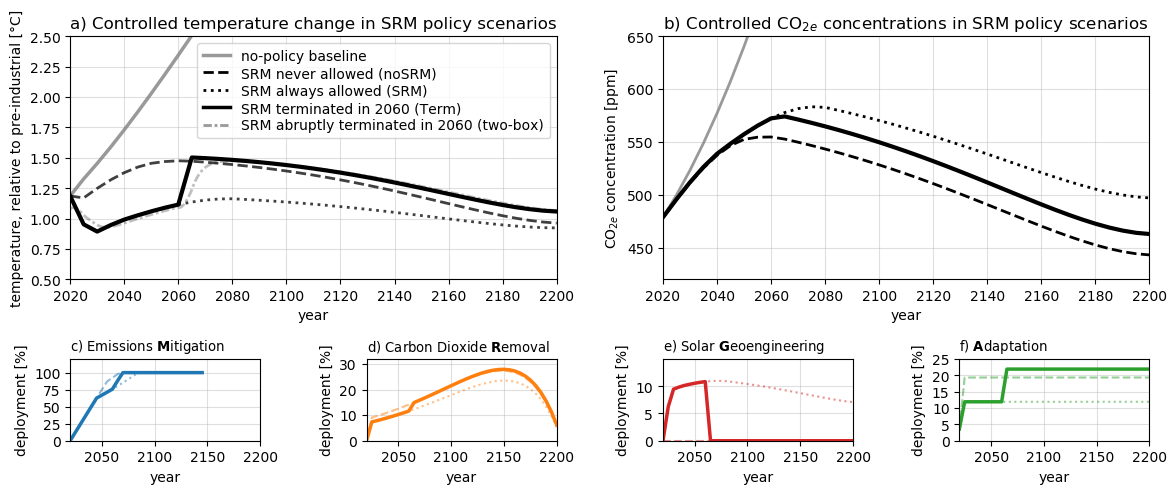

In [15]:
fig1 = figure(figsize=(12,5))
gs = fig1.add_gridspec(6, 8)

##
ax1 = fig1.add_subplot(get(gs, (slice(0,4), slice(0,4))))

ax2 = fig1.add_subplot(get(gs,(slice(4,6), slice(0,2))))
ax2.set_ylim(0, 120)
ax2.set_yticks([0, 25, 50, 75, 100])

ax3 = fig1.add_subplot(get(gs,(slice(4,6), slice(2,4))))
ax3.set_ylim(0, 32)
ax3.set_yticks([0, 10, 20, 30])

ax4 = fig1.add_subplot(get(gs,(slice(4,6), slice(4,6))))
ax4.set_ylim(0, 15)
ax4.set_yticks([0, 5, 10])

ax5 = fig1.add_subplot(get(gs,(slice(4,6), slice(6,8))))
ax5.set_ylim(0, 25)
ax5.set_yticks([0, 5, 10, 15, 20, 25])

ax6 = fig1.add_subplot(get(gs, (slice(0,4), slice(4,8))))

for ax in [ax1, ax2, ax3, ax4, ax5]
    ax.grid(true, alpha=0.4)
    ax.set_xlim(2020., 2200.)
    ax.set_xlabel("year")
end

for ax in [ax2, ax3, ax4, ax5]
    ax.set_ylabel("deployment [%]")
end

##
ax1.plot(t(SRM),T(SRM), "-", color="grey", label="no-policy baseline", lw=2.5, alpha=0.8)
m = noSRM
ax1.plot(t(m),T(m, M=true, R=true, G=true, A=true), color="k", ls="--", lw=2, alpha=0.75)
m = SRM
ax1.plot(t(m),T(m, M=true, R=true, G=true, A=true), color="k", alpha=0.75, ls=":", lw=2)
m = SRM_term
ax1.plot(t_hi, T_hi.*sqrt.(1 .-A_hi), color="k", lw=2., ls=(0., (3,1,1,1)), alpha=0.25)
ax1.plot(t(m),T(m, M=true, R=true, G=true, A=true), color="k", lw=3, ls="-")

ax1.plot([],[], lw=2, ls="--", color="k", label="SRM never allowed (noSRM)")
ax1.plot([],[], lw=2, ls=":", color="k", label="SRM always allowed (SRM)")
ax1.plot([],[], lw=2.5, ls="-", color="k", label="SRM terminated in $(terminate_year) (Term)")
ax1.plot([],[], lw=2., alpha=0.4, ls=(0., (3,1,1,1)), color="k", label="SRM abruptly terminated in $(terminate_year) (two-box)")

ax1.legend(loc="upper right", labelspacing=0.25)
ax1.set_ylim([0.5, 2.5])
ax1.set_ylabel("temperature, relative to pre-industrial [°C]")
ax1.set_title("a) Controlled temperature change in SRM policy scenarios", loc="left")

## 
m = noSRM
qidx = (m.economics.baseline_emissions .> 0)
ax2.plot(t(m)[qidx], m.controls.mitigate[qidx]*100, color="C0", ls="--", lw=1.5, alpha=0.5)
ax3.plot(t(m), m.controls.remove*100, color="C1", ls="--", lw=1.5, alpha=0.5)
ax4.plot(t(m), m.controls.geoeng*100, color="C3", ls="--", lw=1.5, alpha=0.5)
ax5.plot(t(m), m.controls.adapt*100, color="C2", ls="--", lw=1.5, alpha=0.5)

m = SRM
ax2.plot(t(m)[qidx], m.controls.mitigate[qidx]*100, color="C0", ls=":", lw=1.5, alpha=0.5)
ax3.plot(t(m), m.controls.remove*100, color="C1", ls=":", lw=1.5, alpha=0.5)
ax4.plot(t(m), m.controls.geoeng*100, color="C3", ls=":", lw=1.5, alpha=0.5)
ax5.plot(t(m), m.controls.adapt*100, color="C2", ls=":", lw=1.5, alpha=0.5)

m = SRM_term
ax2.plot(t(m)[qidx], m.controls.mitigate[qidx]*100, color="C0", ls="-", lw=2.5)
ax3.plot(t(m), m.controls.remove*100, color="C1", ls="-", lw=2.5)
ax4.plot(t(m), m.controls.geoeng*100, color="C3", ls="-", lw=2.5)
ax5.plot(t(m), m.controls.adapt*100, color="C2", ls="-", lw=2.5)

ax2.set_title(L"c) Emissions $\mathbf{M}$itigation", fontsize=9.5, loc="left")
ax3.set_title(L"d) Carbon Dioxide $\mathbf{R}$emoval", fontsize=9.5, loc="left")
ax4.set_title(L"e) Solar $\mathbf{G}$eoengineering", fontsize=9.5, loc="left")
ax5.set_title(L"f) $\mathbf{A}$daptation", fontsize=9.5, loc="left")

##
m = noSRM
ax6.plot(t(SRM), c(SRM), "-", color="grey", lw=2, alpha=0.8)
ax6.plot(t(m),c(m, M=true, R=true), color="k", ls="--", lw=2)
m = SRM
ax6.plot(t(m),c(m, M=true, R=true), color="k", ls=":", lw=2)
m = SRM_term
ax6.plot(t(m),c(m, M=true, R=true), color="k", ls="-", lw=3)
ax6.set_ylim(420, 650)

ax6.grid(true, alpha=0.4)
ax6.set_xlim(2020., 2200.)
ax6.set_xlabel("year")
ax6.set_ylabel(L"CO$_{2e}$ concentration [ppm]")
ax6.set_title(L"b) Controlled CO$_{2e}$ concentrations in SRM policy scenarios", loc="left")

fig1.tight_layout()
fig1.savefig("figures/SRM_termination_response.png", dpi=200., bbox_inches="tight")


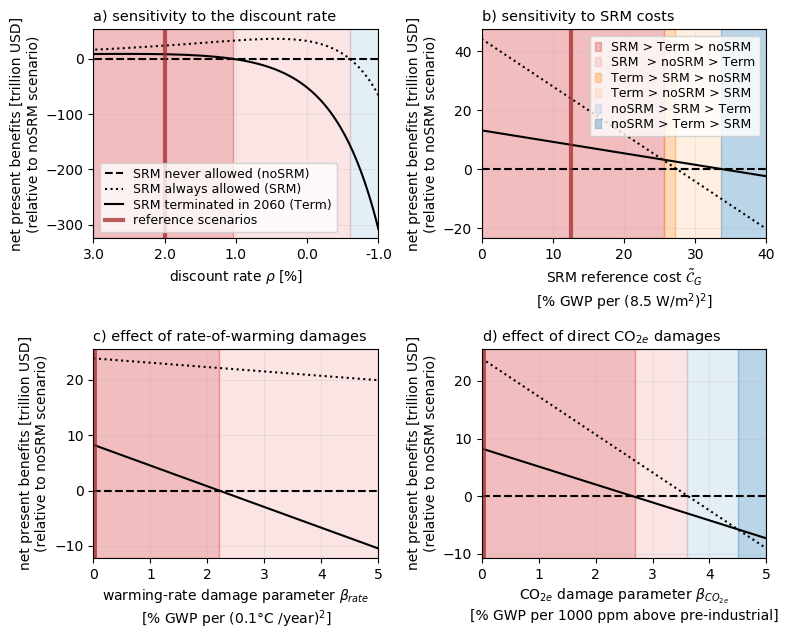

In [14]:
fig2 = figure(figsize=(8, 6.5))
ax1 = fig2.add_subplot(2,2,1)
ax2 = fig2.add_subplot(2,2,2)
#ax3 = fig2.add_subplot(2,2,3)
ax4 = fig2.add_subplot(2,2,3)
ax5 = fig2.add_subplot(2,2,4)

##
ρmax = 0.03
ρmin = -0.01
ρs = -0.01:(ρmax-ρmin)/100.:ρmax;

function NPB(m, ρ)
    tmp = deepcopy(m)
    tmp.economics.ρ = ρ
    return net_present_benefit(tmp, M=true, R=true, G=true, A=true)
end

NPB_mod_SRM_term = [NPB(SRM_term, ρ) for ρ in ρs]
NPB_mod_noSRM = [NPB(noSRM, ρ) for ρ in ρs]
NPB_mod_SRM = [NPB(SRM, ρ) for ρ in ρs]

ax1.grid(true, alpha=0.2)
ax1.plot(ρs, NPB_mod_noSRM-NPB_mod_noSRM, "k--", label="SRM never allowed (noSRM)")
ax1.plot(ρs, NPB_mod_SRM-NPB_mod_noSRM, "k:", label="SRM always allowed (SRM)")
ax1.plot(ρs, NPB_mod_SRM_term-NPB_mod_noSRM, "k-", label="SRM terminated in $(terminate_year) (Term)")
ax1.axvline(SRM.economics.ρ, color="brown", linestyle="-", lw=3, alpha=0.75, label="reference scenarios")
ax1.set_xlim(ρs[end], ρs[1])
yl = ax1.get_ylim()
xt = ρs[1]:(ρmax-ρmin)/4:ρs[end]
ax1.set_xticks(xt)
ax1.set_xticklabels(round.(xt*100, digits=1))

_, i1 = findmin(abs.(NPB_mod_SRM .- NPB_mod_noSRM))
ax1.fill_between([ρs[1], ρs[i1]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.12, color="C0")

_, i2 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_noSRM))
ax1.fill_between([ρs[i1], ρs[i2]], [yl[1], yl[1]], [yl[2], yl[2]], color="C3", alpha=0.12)
ax1.fill_between([ρs[i2], ρs[end]], [yl[1], yl[1]], [yl[2], yl[2]], color="C3", alpha=0.3)

ax1.set_ylim(yl)
ax1.set_ylabel("net present benefits [trillion USD]\n(relative to noSRM scenario)")
ax1.set_xlabel(L"discount rate $\rho$ [%]")
ax1.set_title("a) sensitivity to the discount rate", loc="left", fontsize=10.5)
ax1.legend(labelspacing=0.2, handlelength=1.5, fontsize=9, loc="lower left")

##
CGmax = 0.40
CGs = 0:CGmax/50.:CGmax;

function NPB_CG(m, CG)
    tmp = deepcopy(m)
    tmp.economics.geoeng_cost = CG
    return net_present_benefit(tmp, M=true, R=true, G=true, A=true)
end

NPB_mod_SRM_term = [NPB_CG(SRM_term, CG) for CG in CGs]
NPB_mod_noSRM = [NPB_CG(noSRM, CG) for CG in CGs]
NPB_mod_SRM = [NPB_CG(SRM, CG) for CG in CGs]

ax2.grid(true, alpha=0.2)
ax2.plot(CGs, NPB_mod_noSRM-NPB_mod_noSRM, "k--")
ax2.plot(CGs, NPB_mod_SRM-NPB_mod_noSRM, "k:")
ax2.plot(CGs, NPB_mod_SRM_term-NPB_mod_noSRM, "k-")
ax2.axvline(SRM.economics.geoeng_cost, color="brown", linestyle="-", lw=3, alpha=0.75)
ax2.set_xlim(CGs[1], CGs[end])
yl = ax2.get_ylim()
xt = CGs[1]:CGs[end]/4:CGs[end]
ax2.set_xticks(xt)
ax2.set_xticklabels(Int.(round.(xt*100, digits=1)))

_, i1 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_SRM))
ax2.fill_between([CGs[1], CGs[i1]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.3, color="C3")

_, i2 = findmin(abs.(NPB_mod_SRM .- NPB_mod_noSRM))
ax2.fill_between([CGs[i1], CGs[i2]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.3, color="C1")

_, i3 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_noSRM))
ax2.fill_between([CGs[i2], CGs[i3]], [yl[1], yl[1]], [yl[2], yl[2]], color="C1", alpha=0.12)
ax2.fill_between([CGs[i3], CGs[end]], [yl[1], yl[1]], [yl[2], yl[2]], color="C0", alpha=0.3)

ax2.set_ylim(yl)
ax2.set_ylabel("net present benefits [trillion USD]\n(relative to noSRM scenario)")
ax2.set_xlabel(string(
    L"SRM reference cost $\tilde{\mathcal{C}}_{G}$",
    "\n",
    L"[% GWP per (8.5 W/m$^{2}$)$^{2}$]"
))
ax2.set_title("b) sensitivity to SRM costs", loc="left", fontsize=10.5)
ax2.fill_between([], [], [], color="C3", alpha=0.3, label="SRM > Term > noSRM")
ax2.fill_between([], [], [], color="C3", alpha=0.12, label="SRM  > noSRM > Term")
ax2.fill_between([], [], [], color="C1", alpha=0.3, label="Term > SRM > noSRM")
ax2.fill_between([], [], [], color="C1", alpha=0.12, label="Term > noSRM > SRM")
ax2.fill_between([], [], [], color="C0", alpha=0.12, label="noSRM > SRM > Term")
ax2.fill_between([], [], [], color="C0", alpha=0.3, label="noSRM > Term > SRM")
ax2.legend(labelspacing=0.2, handlelength=0.5, fontsize=9, loc="upper right")

# ##
# βmax = (5. /100.) / (3. .^2) # 10% GWP damages for (3ºC warming).^2
# βs = 0.:βmax/50.:βmax;

# function NPB_β(m, β)
#     tmp = deepcopy(m)
#     tmp.economics.β = β
#     return net_present_benefit(tmp, M=true, R=true, G=true, A=true)
# end

# NPB_mod_SRM_term = [NPB_β(SRM_term, β) for β in βs]
# NPB_mod_noSRM = [NPB_β(noSRM, β) for β in βs]
# NPB_mod_SRM = [NPB_β(SRM, β) for β in βs]

# ax3.grid(true, alpha=0.2)
# ax3.plot(βs, NPB_mod_noSRM-NPB_mod_noSRM, "k--", label="SRM never allowed (noSRM)")
# ax3.plot(βs, NPB_mod_SRM-NPB_mod_noSRM, "k:", label="SRM always allowed (SRM)")
# ax3.plot(βs, NPB_mod_SRM_term-NPB_mod_noSRM, "k-", label="SRM terminated in $(terminate_year) (Term)")
# ax3.axvline(SRM.economics.β, color="brown", linestyle="-", lw=3, alpha=0.75, label="reference scenarios")
# ax3.set_xlim(βs[1], βs[end])
# yl = ax3.get_ylim()
# xt = βs[1]:βs[end]/5:βs[end]
# ax3.set_xticks(xt)
# ax3.set_xticklabels(Int.(round.(xt*(3. ^2)*100, digits=1)))

# _, i1 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_noSRM))
# ax3.fill_between([0, βs[i1]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.1, color="C3", label="SRM > Term > noSRM")
# ax3.fill_between([βs[i1], βs[end]], [yl[1], yl[1]], [yl[2], yl[2]], color="C1", alpha=0.1, label="SRM  > noSRM > Term")

# ax3.set_ylim(yl)
# ax3.set_ylabel("net present benefits [trillion USD]\n(relative to noSRM scenario)")
# ax3.set_xlabel(string(
#     L"climate damage parameter $\beta$",
#     "\n",
#     L"[% GWP per (3°C)$^{2}$]"
# ))
# ax3.set_title("c) sensitivity to climate damage parameter", loc="left", fontsize=10.5)

##
βdTdtmax = (5. /100.) / ((1. /10.)^2) # 10% GWP damages for (1ºC warming in 10 years)^2
βdTdts = 0.:βdTdtmax/50.:βdTdtmax;

NPB_mod_SRM_term = [net_present_benefit_mod(SRM_term, M=true, R=true, G=true, A=true, βdTdt=βdTdt) for βdTdt in βdTdts]
NPB_mod_noSRM = [net_present_benefit_mod(noSRM, M=true, R=true, G=true, A=true, βdTdt=βdTdt) for βdTdt in βdTdts]
NPB_mod_SRM = [net_present_benefit_mod(SRM, M=true, R=true, G=true, A=true, βdTdt=βdTdt) for βdTdt in βdTdts]

ax4.grid(true, alpha=0.2)
ax4.plot(βdTdts, NPB_mod_SRM_term-NPB_mod_noSRM, "k-")
ax4.plot(βdTdts, NPB_mod_noSRM-NPB_mod_noSRM, "k--")
ax4.plot(βdTdts, NPB_mod_SRM-NPB_mod_noSRM, "k:")
ax4.axvline(0., color="brown", linestyle="-", lw=5, alpha=0.75)
ax4.set_xlim(βdTdts[1], βdTdts[end])
yl = ax4.get_ylim()
xt = βdTdts[1]:βdTdts[end]/5:βdTdts[end]
ax4.set_xticks(xt)
ax4.set_xticklabels(Int.(round.(xt*100*((1/10.)^2), digits=1)))

_, i1 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_noSRM))
ax4.fill_between([0, βdTdts[i1]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.3, color="C3", label="SRM > Term > noSRM")
ax4.fill_between([βdTdts[i1], βdTdts[end]], [yl[1], yl[1]], [yl[2], yl[2]], color="C3", alpha=0.12, label="SRM  > noSRM > Term")

ax4.set_ylim(yl)
ax4.set_ylabel("net present benefits [trillion USD]\n(relative to noSRM scenario)")
ax4.set_xlabel(string(
    L"warming-rate damage parameter $\beta_{rate}$",
    "\n",
    L"[% GWP per (0.1°C /year)$^{2}$]"
))
ax4.set_title("c) effect of rate-of-warming damages", loc="left", fontsize=10.5)

##
βCO2max = (5. /100.) / 1000. # 5% GWP damages for 1000 ppm increase in CO2
βCO2s = 0.:βCO2max/50.:βCO2max;

NPB_mod_SRM_term = [net_present_benefit_mod(SRM_term, M=true, R=true, G=true, A=true, βCO2=βCO2) for βCO2 in βCO2s]
NPB_mod_noSRM = [net_present_benefit_mod(noSRM, M=true, R=true, G=true, A=true, βCO2=βCO2) for βCO2 in βCO2s]
NPB_mod_SRM = [net_present_benefit_mod(SRM, M=true, R=true, G=true, A=true, βCO2=βCO2) for βCO2 in βCO2s]

ax5.grid(true, alpha=0.2)
ax5.plot(βCO2s, NPB_mod_SRM_term-NPB_mod_noSRM, "k-")
ax5.plot(βCO2s, NPB_mod_noSRM-NPB_mod_noSRM, "k--")
ax5.plot(βCO2s, NPB_mod_SRM-NPB_mod_noSRM, "k:")
ax5.axvline(0., color="brown", linestyle="-", lw=5, alpha=0.75)
ax5.set_xlim(βCO2s[1], βCO2s[end])
yl = ax5.get_ylim()
xt = βCO2s[1]:βCO2s[end]/5:βCO2s[end]
ax5.set_xticks(xt)
ax5.set_xticklabels(Int.(xt*100*1000))

_, i1 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_noSRM))
ax5.fill_between([0, βCO2s[i1]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.3, color="C3", label="SRM > Term > noSRM")

_, i2 = findmin(abs.(NPB_mod_SRM .- NPB_mod_noSRM))
ax5.fill_between([βCO2s[i1], βCO2s[i2]], [yl[1], yl[1]], [yl[2], yl[2]], color="C3", alpha=0.12, label="SRM  > noSRM > Term")

_, i3 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_SRM))
ax5.fill_between([βCO2s[i2], βCO2s[i3]], [yl[1], yl[1]], [yl[2], yl[2]], color="C0", alpha=0.12, label="noSRM > SRM > Term")

_, i4 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_SRM))
ax5.fill_between([βCO2s[i3], βCO2s[end]], [yl[1], yl[1]], [yl[2], yl[2]], color="C0", alpha=0.3, label="noSRM > Term > SRM")

ax5.set_ylim(yl)
ax5.set_ylabel("net present benefits [trillion USD]\n(relative to noSRM scenario)")
ax5.set_xlabel(string(
    L"CO$_{2e}$ damage parameter $\beta_{CO_{2e}}$",
    "\n[% GWP per 1000 ppm above pre-industrial]"
))
ax5.set_title(L"d) effect of direct CO$_{2e}$ damages", loc="left", fontsize=10.5)

fig2.tight_layout()
fig2.savefig("figures/SRM_termination_sensitivity.png", dpi=200., bbox_inches="tight")